### Importing libraries

In [272]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [313]:
# Reading the data
df = pd.read_csv('train.csv')

df_test = pd.read_csv('test.csv')
df_test_copy = pd.read_csv('test.csv')

In [274]:
df.shape

(6650, 11)

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


In [276]:
df.isnull().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [255]:
df.nunique()

ID                    6650
Age                     52
Gender                   2
Income                   4
Balance               6643
Vintage                  6
Transaction_Status       2
Product_Holdings         3
Credit_Card              2
Credit_Category          3
Is_Churn                 2
dtype: int64

In [277]:
# Drop the ID column
df.drop(["ID"],inplace=True,axis=1)
df_test.drop(["ID"],inplace=True,axis=1)

### Exploratory data analysis

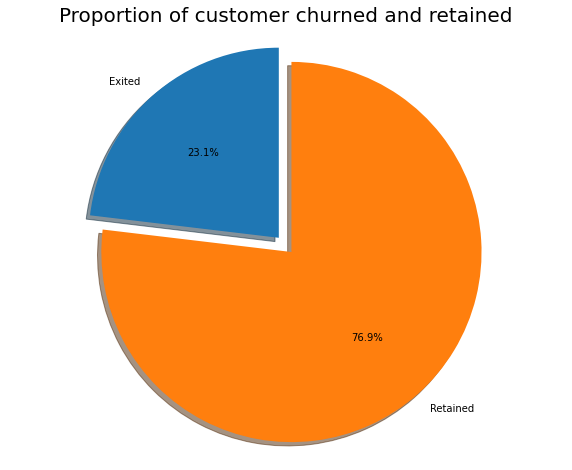

In [200]:
labels = 'Exited', 'Retained'
sizes = [df.Is_Churn[df['Is_Churn']==1].count(), df.Is_Churn[df['Is_Churn']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

#### Observations from the pie chart
- From the above pie chart we can clearly see that the percentage of customers retained is more than that of customers churned in the data.
- The data is imbalanced.
- I will use SMOTE to upsample the churned customers to match them with the retained customers so that the model captures the pattern which will lead to better accuracy

<AxesSubplot:xlabel='Product_Holdings', ylabel='count'>

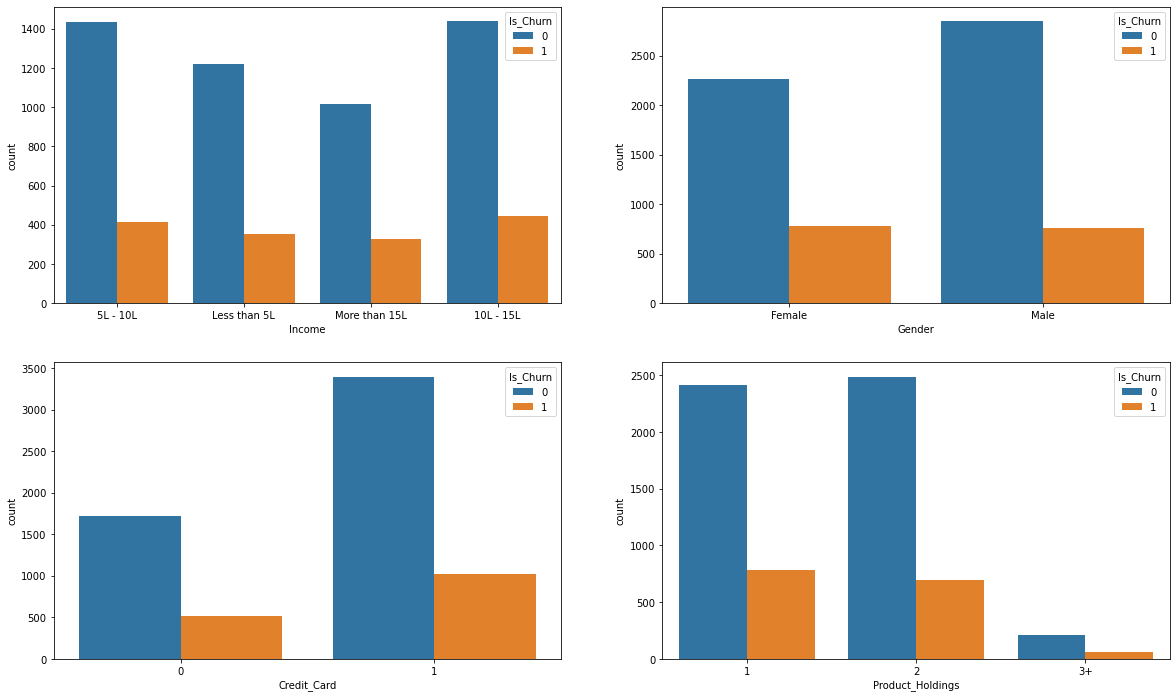

In [201]:
    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Income', hue = 'Is_Churn',data = df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue = 'Is_Churn',data = df, ax=axarr[0][1])
    sns.countplot(x='Credit_Card', hue = 'Is_Churn',data = df, ax=axarr[1][0])
    sns.countplot(x='Product_Holdings', hue = 'Is_Churn',data = df, ax=axarr[1][1])

#### Observations from countplot
- Credit card holders represent more data than non-credit card holders
- Churn rate of both female and male is equal


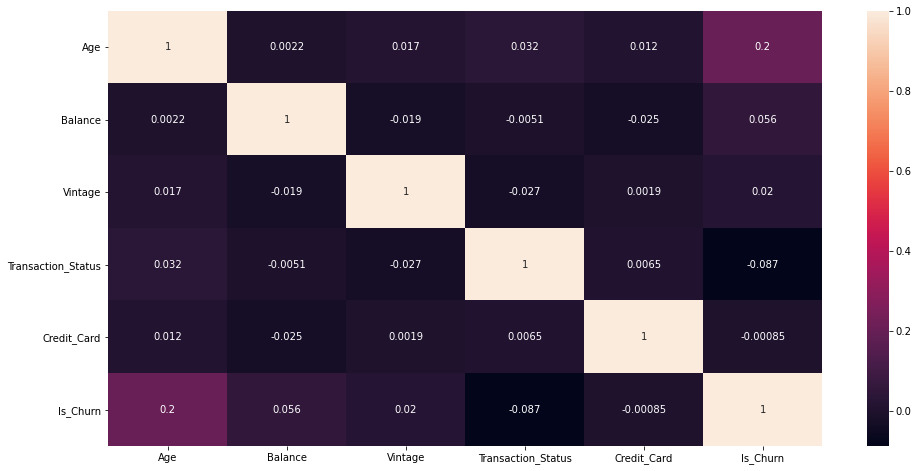

In [118]:
plt.figure(figsize = (16,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [202]:
df.corr()['Is_Churn'].sort_values(ascending=False)

Is_Churn              1.000000
Age                   0.204301
Balance               0.056380
Vintage               0.020152
Credit_Card          -0.000848
Transaction_Status   -0.086917
Name: Is_Churn, dtype: float64

In [204]:
df.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [278]:
df['Is_Churn'].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

In [279]:
X = np.array(df.drop(['Is_Churn'],axis=1).values)
y = np.array(df['Is_Churn'].values)

df_test = np.array(df_test.values)

### Apply one hot encoding

In [280]:
cTransformer = ColumnTransformer([('encoder',OneHotEncoder(drop='first'),[1,2,8,6])], remainder='passthrough')
cTransformer.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', OneHotEncoder(drop='first'),
                                 [1, 2, 8, 6])])

In [281]:
X = cTransformer.transform(X)
df_test = cTransformer.transform(df_test)

In [209]:
X.shape

(6650, 13)

### Apply SMOTE

In [262]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
oversampled_X, oversampled_Y = sm.fit_resample(X,y)

### Feature scaling

In [282]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
oversampled_X = scaler.fit_transform(oversampled_X)
df_test = scaler.transform(df_test) 

In [283]:
X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_Y,test_size=0.2, random_state=42)

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [285]:
def choose_best_params(params,estimator,X,y):
    grid_search_classifier = GridSearchCV(estimator= estimator,
                           param_grid= params, cv =10
                            )

    grid_search_classifier.fit(X, y)
    print(grid_search_classifier.best_params_)
    
    return grid_search_classifier

In [286]:
def validate_result(model,model_name):
    y_pred = model.predict(X_test)
    accuracy_score = metrics.accuracy_score(y_test,y_pred)
    roc_auc_score = metrics.roc_auc_score(y_test,y_pred)
    f1_score = metrics.f1_score(y_test,y_pred)
    
    print('Model: ', model_name)
    print('accuracy_score: ',accuracy_score)
    print('roc_auc_score: ',roc_auc_score)
    print('f1_score: ',f1_score)

###  XGBoost


In [287]:
import xgboost as xgb
xgboost_ = xgb.XGBClassifier()
#param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}

#xgboost_grid_ = choose_best_params(param_grid,xgboost_,X_train,y_train)
xgboost_.fit(X_train,y_train)


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:56:49] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[00:56:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[00:56:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:56:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[00:56:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[00:56:49] INFO: C:/Users/Administrator/workspace/xgbo

[00:56:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[00:56:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[00:56:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[00:56:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[00:56:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[00:56:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [288]:
validate_result(xgboost_,"XGBoost")

Model:  XGBoost
accuracy_score:  0.8406647116324536
roc_auc_score:  0.8401544571258208
f1_score:  0.8212719298245615


### Random forest


In [289]:
from sklearn.ensemble import RandomForestClassifier
random_forest_ = RandomForestClassifier(n_estimators=50, random_state=0)

In [290]:
random_forest_.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, random_state=0)

In [291]:
validate_result(random_forest_,'Random Forest')

Model:  Random Forest
accuracy_score:  0.8362658846529815
roc_auc_score:  0.835848692408247
f1_score:  0.8201825013419216


### Gradient boosting

In [292]:
from sklearn.ensemble import GradientBoostingClassifier

In [293]:
gradient_boost_ = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

In [294]:
validate_result(gradient_boost_,'Gradient boost')

Model:  Gradient boost
accuracy_score:  0.8479960899315738
roc_auc_score:  0.8473211760299053
f1_score:  0.8227920227920228


### Light GBM

In [295]:
from lightgbm import LGBMClassifier

lgbm_ = LGBMClassifier(random_state=5)

lgbm_.fit(X_train, y_train)

LGBMClassifier(random_state=5)

In [296]:
validate_result(lgbm_,"LightGBM")

Model:  LightGBM
accuracy_score:  0.8514173998044966
roc_auc_score:  0.8508261793552628
f1_score:  0.8301675977653631


### SVM

In [226]:
from sklearn.svm import SVC

In [227]:
svc_ = SVC(gamma='auto',random_state=42)
svc_.fit(X_train,y_train)

SVC(gamma='auto', random_state=42)

In [228]:
validate_result(svc_,"SVC")

Model:  SVC
accuracy_score:  0.7908113391984359
roc_auc_score:  0.7899941137348736
f1_score:  0.7476415094339623


### Logistic Regression

In [229]:
from sklearn.linear_model import LogisticRegression 

In [230]:
LR_ = LogisticRegression()
LR_.fit(X_train,y_train)

LogisticRegression()

In [231]:
validate_result(LR_,"Logistic Regression")

Model:  Logistic Regression
accuracy_score:  0.626099706744868
roc_auc_score:  0.6259832738336405
f1_score:  0.6157709693621296


### KNN

In [232]:
 from sklearn.neighbors import KNeighborsClassifier

In [233]:
KNN_ = KNeighborsClassifier()
KNN_.fit(X_train,y_train)

KNeighborsClassifier()

In [314]:
validate_result(KNN_,"KNN")

Model:  KNN
accuracy_score:  0.7214076246334311
roc_auc_score:  0.7213961915100181
f1_score:  0.71976401179941


There was no much improvement in the scores after performing hyperparameter tuning

### From all the applied algorithms, Light GBM is performing slightly better than other models with f1_score being 83%. We will use LightGBM to predict for the test data


### Predict for test data

In [297]:
df_test_pred = lgbm_.predict(df_test)

In [298]:
df_test_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [302]:
pred_data = list(zip(df_test_copy['ID'],df_test_pred))

In [303]:
pred_df = pd.DataFrame(pred_data,columns=["ID","Is_Churn"])

In [309]:
pred_df['Is_Churn'].value_counts()

0    2717
1     134
Name: Is_Churn, dtype: int64

In [312]:
pred_df.to_csv('submission.csv',index=False)